## Prediction of Commission based on Market Share and Revenue

The objective of this notebook is to predict the Commission based on Market share and Revenue for the respective companies.

In [129]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split,KFold,learning_curve
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [98]:
df = pd.read_csv('/kaggle/input/sales-data/Interview_Pi.csv')
df.head(5)

,Unnamed: 0,YEAR,MONTH,Company,Area 1,Area 2,Area 3,Area 3 Classification,Outlet Type,Outlet Name,Product Category 1,Product Category 2,Product,Units sold,Revenue,Commission
0,0,2018,JAN,Brand ABC,the west,Washington,New York City,Class 1,Outlet_A,viserys ii targaryen,korean,bagels,white cabbage,2.495851,49717.353917,0.000000
1,1,2018,FEB,Brand ABC,the east,Minnesota,Los Angeles,Class 2,Outlet_B,walder frey,greek,chicken bouillon granules,rye,45.198292,249494.572083,0.000000
2,2,2018,JUN,Brand XYZ,the north,Utah,Chicago,Class 2,Outlet_C,addison hill,korean,dry yeast,wheels,2.475006,54351.125584,4393.135151
3,3,2018,FEB,Brand ABC,the south,New Hampshire,Houston,Class 1,Outlet_D,aemma arryn,mexican,chicken bouillon granules,cola soft drink,4.980233,33467.167489,0.000000
4,4,2018,JAN,Brand ABC,the sky,Idaho,Phoenix,Class 2,Outlet_E,sylva santagar,indian,field peas,mexican oregano,2.482338,27256.068984,0.000000


# Data Wrangling

Commission and Revenue for a product and company cannot be zero. In the dataset, the cases are:

* Either Commission is nil or Revenue is nill
* Both Commission and Revenue is nill

The nill values have to be replaced with the mean of the respective columns.

In [99]:
df= df.replace(to_replace = 0,value= np.nan)
df['Revenue'] = df['Revenue'].fillna(value = df['Revenue'].mean())
df['Commission'] = df['Commission'].fillna(value=df['Revenue'].mean())
df.head(5)

,Unnamed: 0,YEAR,MONTH,Company,Area 1,Area 2,Area 3,Area 3 Classification,Outlet Type,Outlet Name,Product Category 1,Product Category 2,Product,Units sold,Revenue,Commission
0,NaN,2018,JAN,Brand ABC,the west,Washington,New York City,Class 1,Outlet_A,viserys ii targaryen,korean,bagels,white cabbage,2.495851,49717.353917,233735.086055
1,1.0,2018,FEB,Brand ABC,the east,Minnesota,Los Angeles,Class 2,Outlet_B,walder frey,greek,chicken bouillon granules,rye,45.198292,249494.572083,233735.086055
2,2.0,2018,JUN,Brand XYZ,the north,Utah,Chicago,Class 2,Outlet_C,addison hill,korean,dry yeast,wheels,2.475006,54351.125584,4393.135151
3,3.0,2018,FEB,Brand ABC,the south,New Hampshire,Houston,Class 1,Outlet_D,aemma arryn,mexican,chicken bouillon granules,cola soft drink,4.980233,33467.167489,233735.086055
4,4.0,2018,JAN,Brand ABC,the sky,Idaho,Phoenix,Class 2,Outlet_E,sylva santagar,indian,field peas,mexican oregano,2.482338,27256.068984,233735.086055


In [100]:
df['Units sold'] = df['Units sold'].round(0)
df['Revenue'] = df['Revenue'].round(0)
df['Commission'] = df['Commission'].round(0)

## Exploratory Data Analysis

As per the Business requirement, Market share has to be used as a feature for predicting the Commission amount.

To acheive this, the market share is calculated as follows.

Market share = Total units sold for a particular product by a company / Total units sold by all companies

In [130]:
df['Company'].unique()

array(['Brand ABC', 'Brand XYZ'], dtype=object)

Upon analysis, it is observed that there are only two brands in the data set. Hence, products with respect to each of the companies is segregated.

In [101]:
df_company1 = df[['Company','Product']].loc[df['Company'] == 'Brand ABC']
df_company1 = df_company1.drop_duplicates(subset=['Product'])
df_company1 = df_company1.reset_index()
df_company1 = df_company1.drop(columns='index',axis=1)
df_company1

,Company,Product
0,Brand ABC,white cabbage
1,Brand ABC,rye
2,Brand ABC,cola soft drink
3,Brand ABC,mexican oregano
4,Brand ABC,cottage cheese
...,...,...
237,Brand ABC,cod fillets
238,Brand ABC,buckwheat soba noodles
239,Brand ABC,wasabi powder
240,Brand ABC,reduced fat coconut milk


In [102]:
df_company2 = df[['Company','Product']].loc[df['Company'] == 'Brand XYZ']
df_company2 = df_company2.drop_duplicates(subset=['Product'])
df_company2 = df_company2.reset_index()
df_company2 = df_company2.drop(columns='index',axis=1)
df_company2

,Company,Product
0,Brand XYZ,wheels
1,Brand XYZ,green olives
2,Brand XYZ,scallops
3,Brand XYZ,bacon rind
4,Brand XYZ,runny honey
...,...,...
73,Brand XYZ,spanish paprika
74,Brand XYZ,coffee liqueur
75,Brand XYZ,whitefish fillets
76,Brand XYZ,daal


#### Calculation of Total units sold for each product

In [103]:
df_mean = pd.DataFrame()
df_mean1 = pd.DataFrame()
df_prod = df['Product'].unique()
for i in df_prod:    
                        df1 = df[['Units sold']].loc[(df['Product'] == i)]
                        df_mean['Total Units sold'] = df1.sum()
                        df_mean1 = df_mean1.append(df_mean)
df_mean1 = df_mean1.reset_index()
df_mean1 = df_mean1.drop(columns='index',axis=1)
df_prod1 = pd.DataFrame(columns=['Product'],data=df_prod)
df_prod1 = df_prod1.merge(df_mean1,how='outer',on=df_mean1.index)
df_prod1 = df_prod1.drop(columns='key_0',axis=1)

In [104]:
df_prod1 = df_prod1.merge(df_company1,how='outer',on=['Product'])
df_prod1 = df_prod1.fillna(value='Brand XYZ')
df_prod1

,Product,Total Units sold,Company
0,white cabbage,130112.0,Brand ABC
1,rye,2390366.0,Brand ABC
2,wheels,11854.0,Brand XYZ
3,cola soft drink,81258.0,Brand ABC
4,mexican oregano,44700.0,Brand ABC
...,...,...,...
315,buckwheat soba noodles,413.0,Brand ABC
316,wasabi powder,15.0,Brand ABC
317,reduced fat coconut milk,7.0,Brand ABC
318,vine tomatoes,6.0,Brand XYZ


### Calculation of Market share for each product

The Market share value for each product is calculated by dividing the Total units sold for each product and the 

In [105]:
total_units = df[['Units sold']].sum()
df4 = pd.DataFrame()
for i in df_prod:
                    df2 = df_prod1[['Total Units sold']].loc[df_prod1['Product'] == i]
                    df3 = (df2 / total_units['Units sold']) * 100
                    df4 = df4.append(df3)
                    
                    
df_prod1 = df_prod1.merge(df4,how='outer',on=df4.index)
df_prod1 = df_prod1.rename(columns=({'Total Units sold_x':'Total Units sold','Total Units sold_y':'Market Share'}))
df_prod1 = df_prod1.drop(columns='key_0',axis=1)
df_prod1

,Product,Total Units sold,Company,Market Share
0,white cabbage,130112.0,Brand ABC,0.373875
1,rye,2390366.0,Brand ABC,6.868674
2,wheels,11854.0,Brand XYZ,0.034062
3,cola soft drink,81258.0,Brand ABC,0.233493
4,mexican oregano,44700.0,Brand ABC,0.128445
...,...,...,...,...
315,buckwheat soba noodles,413.0,Brand ABC,0.001187
316,wasabi powder,15.0,Brand ABC,0.000043
317,reduced fat coconut milk,7.0,Brand ABC,0.000020
318,vine tomatoes,6.0,Brand XYZ,0.000017


#### Calculation of Total Revenue for each product

The Revenue value for each product is calculated by determining the sum of the Revenue of the respective outlets.

In [106]:
df_mean = pd.DataFrame()
df_mean1 = pd.DataFrame()
df_prod = df['Product'].unique()
for i in df_prod:    
                        df1 = df[['Revenue']].loc[(df['Product'] == i)]
                        df_mean['Revenue'] = df1.sum()
                        df_mean1 = df_mean1.append(df_mean.round(0))
df_mean1 = df_mean1.reset_index()
df_mean1 = df_mean1.drop(columns='index',axis=1)
df_prod1 = df_prod1.merge(df_mean1,how='outer',on=df_mean1.index)
df_prod1 = df_prod1.drop(columns='key_0',axis=1)
df_prod1

,Product,Total Units sold,Company,Market Share,Revenue
0,white cabbage,130112.0,Brand ABC,0.373875,2.591652e+09
1,rye,2390366.0,Brand ABC,6.868674,1.319514e+10
2,wheels,11854.0,Brand XYZ,0.034062,2.604696e+08
3,cola soft drink,81258.0,Brand ABC,0.233493,5.461883e+08
4,mexican oregano,44700.0,Brand ABC,0.128445,4.910606e+08
...,...,...,...,...,...
315,buckwheat soba noodles,413.0,Brand ABC,0.001187,1.589398e+07
316,wasabi powder,15.0,Brand ABC,0.000043,4.674700e+05
317,reduced fat coconut milk,7.0,Brand ABC,0.000020,4.674700e+05
318,vine tomatoes,6.0,Brand XYZ,0.000017,4.674700e+05


#### Calculation of Commission for each product

The commission value for each product is calculated by determining the sum of the commission of the respective outlets.

In [107]:
df_mean = pd.DataFrame()
df_mean1 = pd.DataFrame()
df_prod = df['Product'].unique()
for i in df_prod:    
                        df1 = df[['Commission']].loc[(df['Product'] == i)]
                        df_mean['Commission'] = df1.sum()
                        df_mean1 = df_mean1.append(df_mean.round(0))
df_mean1 = df_mean1.reset_index()
df_mean1 = df_mean1.drop(columns='index',axis=1)
df_prod1 = df_prod1.merge(df_mean1,how='outer',on=df_mean1.index)
df_prod1 = df_prod1.drop(columns='key_0',axis=1)
df_prod1

,Product,Total Units sold,Company,Market Share,Revenue,Commission
0,white cabbage,130112.0,Brand ABC,0.373875,2.591652e+09,2.088915e+09
1,rye,2390366.0,Brand ABC,6.868674,1.319514e+10,3.824489e+09
2,wheels,11854.0,Brand XYZ,0.034062,2.604696e+08,1.408381e+08
3,cola soft drink,81258.0,Brand ABC,0.233493,5.461883e+08,1.608557e+09
4,mexican oregano,44700.0,Brand ABC,0.128445,4.910606e+08,8.442522e+08
...,...,...,...,...,...,...
315,buckwheat soba noodles,413.0,Brand ABC,0.001187,1.589398e+07,1.589398e+07
316,wasabi powder,15.0,Brand ABC,0.000043,4.674700e+05,4.674700e+05
317,reduced fat coconut milk,7.0,Brand ABC,0.000020,4.674700e+05,4.674700e+05
318,vine tomatoes,6.0,Brand XYZ,0.000017,4.674700e+05,4.674700e+05


From the above resulting table, it is inferred that all the required features for predicting the commission has been retrieved successfully for the respective products.

### Correlation Analysis

Inital correlation analysis done based on Pearson coefficient.

#### **Relation between Market share and Commission**

In [108]:
df_prod1[['Market Share','Commission']].corr()

,Market Share,Commission
Market Share,1.000000,0.411357
Commission,0.411357,1.000000


<AxesSubplot:xlabel='Market Share', ylabel='Commission'>

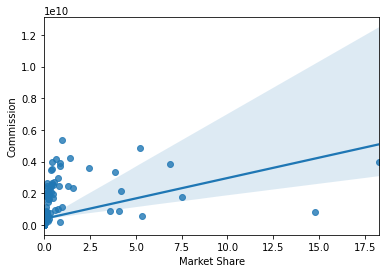

In [109]:
sns.regplot(x=df_prod1['Market Share'],y=df_prod1['Commission'])

Market share and Commission fields have a moderate correlation value of 0.4. The plot indicates a positive correlation between the variables. Also, as the Market share increases, there is a deviation of the data points away from the regression line indicating the presence of outliers. This implies that increase in share value causes an increase in commmission.

#### **Relation between Revenue and Commission**

In [110]:
df_prod1[['Revenue','Commission']].corr()

,Revenue,Commission
Revenue,1.000000,0.491031
Commission,0.491031,1.000000


<AxesSubplot:xlabel='Revenue', ylabel='Commission'>

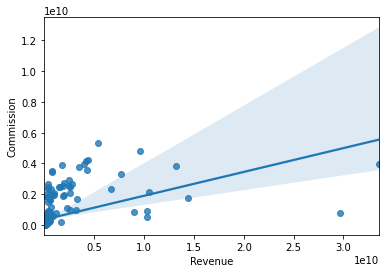

In [111]:
sns.regplot(x=df_prod1['Revenue'],y=df_prod1['Commission'])

Revenue and Commission have a moderate correlation value of 0.5. The graph indicates a positive correlation. As the Revenue increases, Commission increases. There is less deviation of data points from the regression line which indicates less outliers.

#### **Outlier Detection**

Presence of huge amount of outliers can impact the performance of the model. Hence, some of the outliers can be eradicted by using Data Normalisation techniques like Z-score and IQR range.

**Market Share - Outliers**

<AxesSubplot:ylabel='Market Share'>

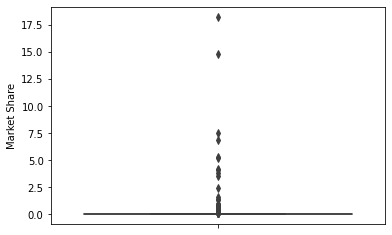

In [112]:
sns.boxplot(y=df_prod1['Market Share'])

**Revenue - Outlier Detection**

<AxesSubplot:ylabel='Revenue'>

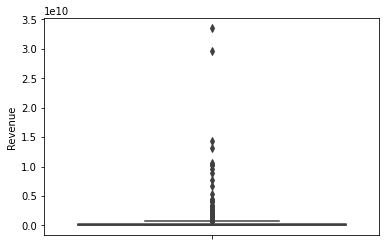

In [113]:
sns.boxplot(y=df_prod1['Revenue'])

**Commission - Outlier Detection**

<AxesSubplot:ylabel='Commission'>

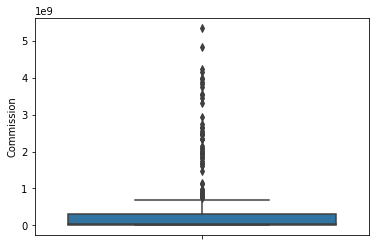

In [114]:
sns.boxplot(y=df_prod1['Commission'])

#### Outlier Elimination based on Z-Score normalisation(Kurtosis)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


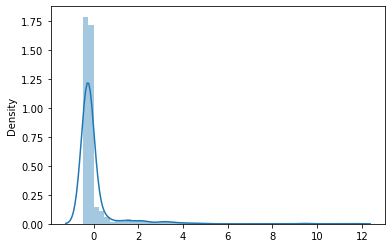

In [115]:
df4 = df_prod1[['Market Share','Revenue','Commission']]
z_score = stats.zscore(df4)
sns.distplot(z_score,hist=True);

As per the distribution plot, it is observed that the curve has decent peak and is well balanced on both sides. However, it indicates the presence of outliers.

In [116]:
np.where(z_score>3)

(array([ 1,  1,  1,  5,  5,  6,  6,  6,  7,  7,  8, 10, 11, 17, 23, 29, 29,
        30, 30, 33, 39, 40, 43, 46, 60]),
 array([0, 1, 2, 0, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 1, 0, 1, 1, 2, 2,
        1, 2, 2]))

In [117]:
df4 = df4[(z_score<3).all(axis=1)]
df4.shape

(303, 3)

#### Outlier elimination based on Interquartile range from upper and lower extremes

The Box plot is considered to be divided as quartiles. The below are the denotions.

* Q1 - Indicates the Lower quartile
* Q3 - Indicates the upper quartile
* Inter Quartile range - the Mean/Average of the complete box plot. It is determined based on the difference between upper and lower extreme
* Based on the IQR and the upper , lower quartile, the upper and lower extremes can be determined.

In [118]:
Q1 = df4.quantile(0.25)
Q3 = df4.quantile(0.75)
IQR = Q3-Q1
df5 = df4[~((df4 < (Q1-1.5*IQR))| (df4 > (Q3+1.5*IQR))).any(axis=1)]
df5.shape

(239, 3)

Applying the Data Normalisation and IQR techniques, the outliers have been considerably reduced. Hence, the dataset can be used further for model development.

## Model Development

The objective is to predict Commission value which is a numeric value. Also the feature dependent are also Numeric.So, a regression model can be used. Hence, the learning curve of the below models have to be visualised to look for overfitting or underfitting cases.

* XGBoost Regressor
* Random Forest Regressor
* Linear Regression
* Lasso Regression
* Ridge Regression

#### Learning Curve and Cross Validation

In [119]:
def plot_curve(estimator,x,y,cv= KFold(),m=np.linspace(0.5,1,5)):
                        
                            size,score_train,score_test= learning_curve(estimator,x,y,train_sizes=m)
                            mean_train = np.mean(score_train,axis=1)
                            mean_test = np.mean(score_test,axis=1)
                            std_train = np.std(score_train,axis=1)
                            std_test = np.std(score_test,axis=1)
                            plt.fill_between(size,mean_train - std_train,mean_train + std_train,alpha=0.1)
                            plt.fill_between(size,mean_test - std_test,mean_test + std_test,alpha=0.1)
                            plt.plot(size,mean_train,label='Training samples')
                            plt.plot(size,mean_test,label='Cross-Validation set')
                            plt.xlabel('Training samples')
                            plt.ylabel('Error')
                            plt.legend()
                            plt.title('Learning curve')

In [120]:
def prediction(model):
                        
                        
                        x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3,random_state=4)
                        model = model.fit(x_train,y_train)
                        yhat = model.predict(x_test)
                        df_pred = x_test
                        df_pred['Commission'] = yhat
                        df_pred['Actual values'] = y_test
                        from sklearn.metrics import accuracy_score,mean_squared_error,r2_score,mean_absolute_error
                        print('MSE:',mean_squared_error(y_test,yhat))
                        print('R2:',r2_score(y_test,yhat))
                        print('MAE:',mean_absolute_error(y_test,yhat))
                        

                        return df_pred

#### Linear Regression

MSE: 1420501076239296.5
R2: 0.8247235935830792
MAE: 21039907.75144919


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Market Share,Revenue,Commission,Actual values
279,0.000474,8414460.0,1.473588e+07,8414460.0
167,0.000069,1636145.0,1.026749e+07,1636145.0
166,0.000046,934940.0,9.950880e+06,934940.0
168,0.000284,4674700.0,1.253133e+07,4674700.0
144,0.000003,18371.0,9.436573e+06,233735.0
...,...,...,...,...
228,0.002178,49084350.0,3.595180e+07,49084350.0
204,0.000652,9583135.0,1.633969e+07,9583135.0
191,0.036959,336343079.0,3.608340e+08,347797680.0
181,0.025764,358549490.0,2.791092e+08,358549490.0


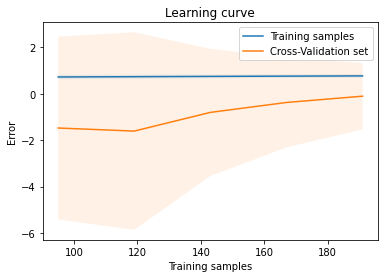

In [121]:
x = df5[['Market Share','Revenue']]
y = df5[['Commission']]
lr = LinearRegression()
plot_curve(lr,x,y)
prediction(lr)

#### Ridge Regression

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.71088e-19): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.62566e-19): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.55678e-19): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.49973e-19): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.45133e-19): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAl

MSE: 2438240162573576.0
R2: 0.6991442098666094
MAE: 23083204.547124166


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.18822e-19): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.86239e-19): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,Market Share,Revenue,Commission,Actual values
279,0.000474,8414460.0,1.908380e+07,8414460.0
167,0.000069,1636145.0,1.298070e+07,1636145.0
166,0.000046,934940.0,1.235222e+07,934940.0
168,0.000284,4674700.0,1.572172e+07,4674700.0
144,0.000003,18371.0,1.152873e+07,233735.0
...,...,...,...,...
228,0.002178,49084350.0,5.559191e+07,49084350.0
204,0.000652,9583135.0,2.015251e+07,9583135.0
191,0.036959,336343079.0,3.169115e+08,347797680.0
181,0.025764,358549490.0,3.350030e+08,358549490.0


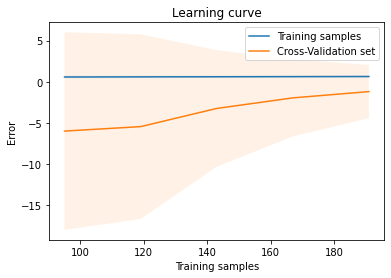

In [122]:
x = df5[['Market Share','Revenue']]
y = df5[['Commission']]
r = Ridge(alpha=0.1)
plot_curve(r,x,y)
prediction(r)

#### Lasso Regression

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.009043819628904e+16, tolerance: 52675635738508.88
  positive)


MSE: 1420500879431623.0
R2: 0.8247236178672859
MAE: 21039908.07369405


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Market Share,Revenue,Commission,Actual values
279,0.000474,8414460.0,1.473588e+07,8414460.0
167,0.000069,1636145.0,1.026749e+07,1636145.0
166,0.000046,934940.0,9.950879e+06,934940.0
168,0.000284,4674700.0,1.253133e+07,4674700.0
144,0.000003,18371.0,9.436571e+06,233735.0
...,...,...,...,...
228,0.002178,49084350.0,3.595179e+07,49084350.0
204,0.000652,9583135.0,1.633969e+07,9583135.0
191,0.036959,336343079.0,3.608340e+08,347797680.0
181,0.025764,358549490.0,2.791092e+08,358549490.0


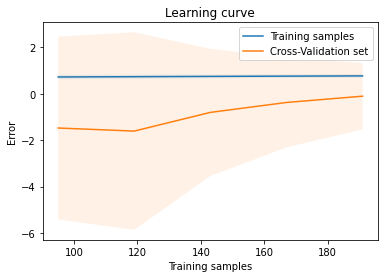

In [123]:
x = df5[['Market Share','Revenue']]
y = df5[['Commission']]
l = Lasso(alpha=0.1)
plot_curve(l,x,y)
prediction(l)

#### XGBoost Regressor

MSE: 2469768572569708.5
R2: 0.6952539020755082
MAE: 23833082.674913194


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Market Share,Revenue,Commission,Actual values
279,0.000474,8414460.0,8.668693e+06,8414460.0
167,0.000069,1636145.0,1.733654e+06,1636145.0
166,0.000046,934940.0,7.778914e+05,934940.0
168,0.000284,4674700.0,7.218864e+06,4674700.0
144,0.000003,18371.0,2.359300e+05,233735.0
...,...,...,...,...
228,0.002178,49084350.0,2.323128e+07,49084350.0
204,0.000652,9583135.0,1.033941e+07,9583135.0
191,0.036959,336343079.0,2.492065e+08,347797680.0
181,0.025764,358549490.0,1.730111e+08,358549490.0


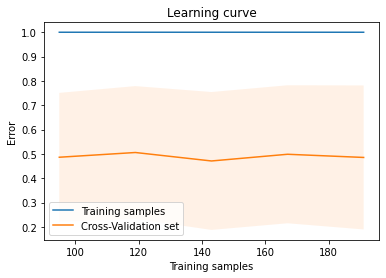

In [126]:
x = df5[['Market Share','Revenue']]
y = df5[['Commission']]
re = XGBRegressor()
plot_curve(re,x,y)
prediction(re)

#### Random Forest Regressor

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 

MSE: 1954152664502727.0
R2: 0.7588760315966219
MAE: 21151834.12375


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Market Share,Revenue,Commission,Actual values
279,0.000474,8414460.0,7.497820e+06,8414460.0
167,0.000069,1636145.0,1.770065e+06,1636145.0
166,0.000046,934940.0,1.164741e+06,934940.0
168,0.000284,4674700.0,6.618317e+06,4674700.0
144,0.000003,18371.0,2.337350e+05,233735.0
...,...,...,...,...
228,0.002178,49084350.0,3.178055e+07,49084350.0
204,0.000652,9583135.0,9.512680e+06,9583135.0
191,0.036959,336343079.0,2.348820e+08,347797680.0
181,0.025764,358549490.0,2.123052e+08,358549490.0


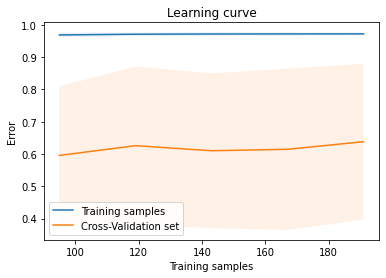

In [125]:
x = df5[['Market Share','Revenue']]
y = df5[['Commission']]
rtree = RandomForestRegressor()
plot_curve(rtree,x,y)
prediction(rtree)

### Inference

Based on the regression model's learning curve and prediction, below insights are enlisted.

* XGBoost Regressor: This model has r2 score of 0.75 and the learning curve shows high deviation. Hence, this model may not be suitable.
* Random Forest Regressor : This model has has r2 score of 0.75. But the learning curve shows high deviation. hence, this model is also not suitable.
* Ridge Regression: This model has r2 score of 0.69 and the learning curve shows low bias and variance.
* Lasso Regression: This model has r2 score of 0.8247236178672859 and the learning curve shows low bias and variance.
* Linear Regression: This model has r2 score of 0.8247235935830792 and the learning curve shows low bias and variance. There is a lesser gap between the CV and the trained set.

On comparing all models, Linear regression seems apt for predicting the commission for each product.
